<a href="https://colab.research.google.com/github/Murcha1990/ML_AI24/blob/main/Hometasks/Base/AI_HW3_Classification_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 3. Линейная классификация. Работа с признаками**

### **Оценивание и штрафы**

Кака всегда - каждая из задач имеет «стоимость» (указана в скобках около задачи).

В задании три части:

- Часть 1 (2.5 балла): написание логистической регрессии своими руками
- Часть 2 (5 баллов): различные методы отбора признаков
- Часть 3 (3.5 балла): обучение моделей классификации на текстах

Всего за задание можно получить 11 баллов, но:

**Балл за задание = min{ваш балл, 10}.**

In [1]:
%pylab inline
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import ttest_ind
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# **Часть 1. Логистическая регрессия своими руками (2.5 балла)**

## **Задание 1. Реализуйте класс логистической регрессии, обучаемой с помощью:**

**Задание 1.1 (1 балл). Градиентного спуска**

**Задание 1.2 (1 балл). Стохастического градиентного спуска**

До этого вы писали код без ограничений. Здесь же необходимо соблюдать следующие условия:

- Градиентный спуск необходимо записать в векторном виде;
- Циклы средствами python допускается использовать только для итераций градиентного спуска;

**Класс градиентного спуска должен:**
- В качестве критерия останова использовать (одновременно):
  - проверку на евклидову норму разности весов на двух соседних итерациях задаваемого параметром `tolerance`;
  - достижение максимального числа итераций, задаваемого параметром `max_iter`.
- Обладать атрибутом `loss_history`. В нём после вызова метода fit должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту). Данный атрибут необходим, чтобы проследить, что оптимизационный процесс действительно сходится;
- Инициализировать веса случайным образом или нулевым вектором (на ваш выбор).

Полезно [почитать](https://scikit-learn.org/stable/developers/develop.html).

**Шаблон класса описан ниже, вам нужно реализовать каждую из заготовленных функций.**

**ВАЖНО!** Мы заполняем данный шаблон, даже если он нам не нравится. Менять структуру класса и писать по-своему запрещено - за это будут сняты баллы.

In [2]:
# Преобразование для логрега
def sigmoid(Xw):
    return 1 / (1 + np.exp(-Xw))

class LogReg(BaseEstimator):
    def __init__(self, gd_type='stochastic',
                 tolerance=1e-4, max_iter=1000, w0=None, eta=1e-2):
        """
        gd_type: 'full' or 'stochastic'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) — init weights
        eta: learning rate
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.w = None
        self.eta = eta
        self.loss_history = None # list of loss function values at each training iteration

    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """
        self.loss_history = []

        # Инициализация весов
        if self.w0 is None:
            self.w = np.zeros(X.shape[1])
        else:
            self.w = self.w0.copy()

        # Добавляем в loss_history значение функции потерь до обновления весов
        self.loss_history.append(self.calc_loss(X, y))

        # Градиенты
        for i in range(self.max_iter):
            if self.gd_type == 'full':
                grad = self.calc_gradient(X, y)
            else:
                idr = np.random.randint(0, X.shape[0])
                grad = self.calc_gradient(X[idr:idr+1, :], y[idr:idr+1])
            
            # Сохраняем старые веса и обновляем текущие
            w_old = self.w.copy()
            self.w = self.w - self.eta * grad

            # Сохраняем значение функции потерь после шага
            self.loss_history.append(self.calc_loss(X, y))

            # Проверка критерия останова
            if np.linalg.norm(self.w - w_old) < self.tolerance:
                break

        return self

    def predict_proba(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        return sigmoid(X @ self.w)

    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        return (self.predict_proba(X) > 0.5).astype(int)

    def calc_gradient(self, X, y):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        pred = sigmoid(X @ self.w)
        grad = (X.T @ (pred - y)) / X.shape[0]
        return grad

    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float
        """
        pred = sigmoid(X @ self.w)
        eps = 1e-15 # маленький сдвиг, чтобы избежать деление на 0 в логарифме
        loss = -np.mean(y * np.log(pred + eps) + (1-y) * np.log(1 - pred + eps))
        return loss

Теперь проверим работу вашего класса на синтетических данных.

In [4]:
X, y = make_classification(
    n_samples=100000, n_features=20, n_informative=10, n_redundant=10,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

**Важно:** далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

## **Задание 2 (0.5 балла)**

Обучите логистическую регрессию на синтетических данных.

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC и PR кривые. Проинтерпретируйте результат.

In [5]:
# Функция для получения метрик и построения ROC, PR кривых
def plot_metrics(y_true, y_pred):
    # ROC-AUC
    roc_auc = roc_auc_score(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_pred)

    # PR-AUC
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)

    # Вывод метрик
    print(f"ROC-AUC: {roc_auc:.3f}")
    print(f"PR-AUC: {pr_auc:.3f}")

    # Графики
    plt.figure(figsize=(12, 6))

    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve")
    plt.legend()

    # PR Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve")
    plt.legend()

    plt.tight_layout()
    plt.show()

Grad descent type: full
Learning time: 1.943
ROC-AUC: 0.926
PR-AUC: 0.924


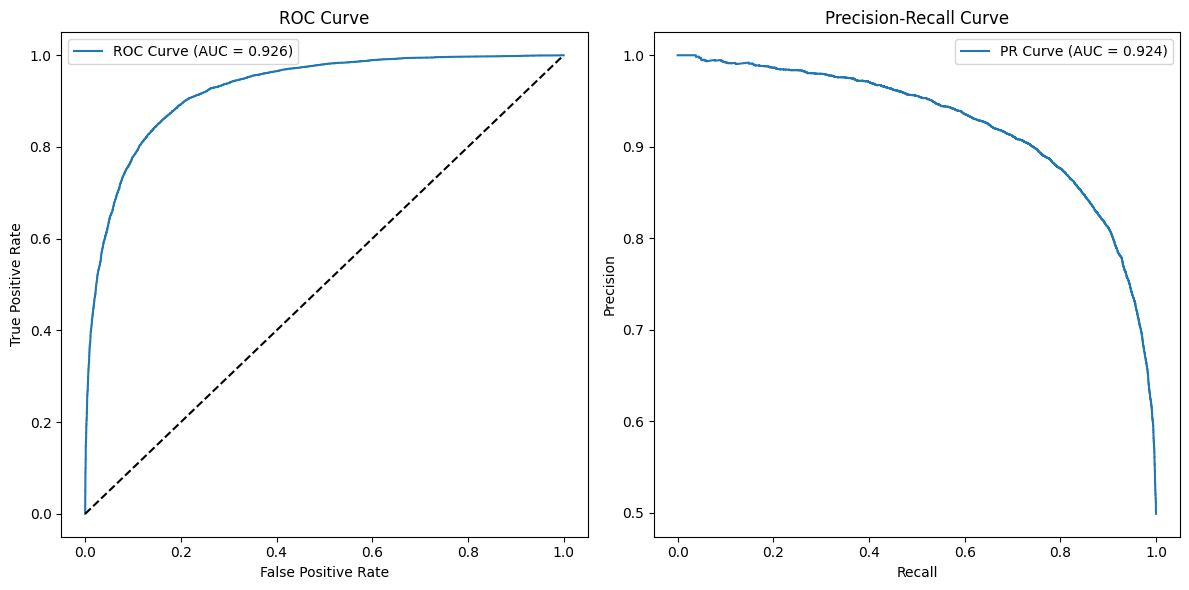

Grad descent type: stochastic
Learning time: 0.206
ROC-AUC: 0.874
PR-AUC: 0.873


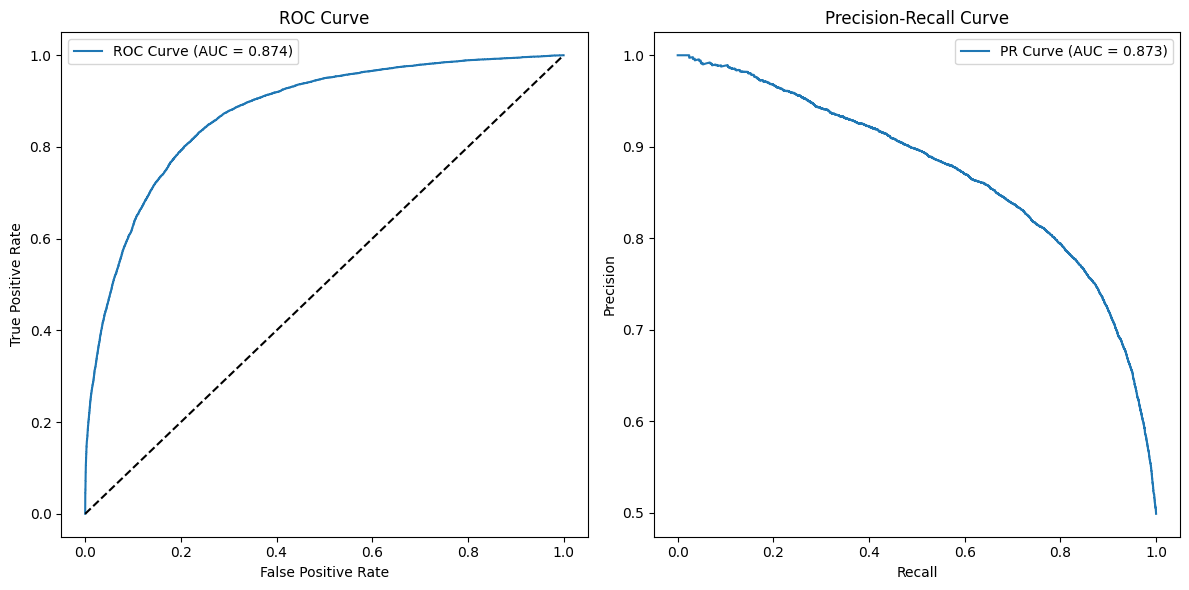

In [6]:
# Кастомный логрег
for gd in ['full', 'stochastic']:
    start_time = time.time()
    lr = LogReg(gd_type=gd)
    lr.fit(X_train, y_train)
    y_pred = lr.predict_proba(X_test)
    print(f'Grad descent type: {gd}')
    print(f'Learning time: {time.time() - start_time:.3f}')
    plot_metrics(y_test, y_pred)

`Вывод`
* Близкие значения ROC-AUC для двух моделей показывают, что модели показывают схожее качество для разных методов градиентного спуска (классический немного точнее стохастического, что логично)
* Время обучения модели с классическим градиентным спуском значительно (примерно в 10 раз) дольше, чем модели со стахастическом спуском
* Для классического градиентного спуска Precision остаётся выше на протяжении большей части диапазона Recall


ROC-AUC: 0.926
PR-AUC: 0.925


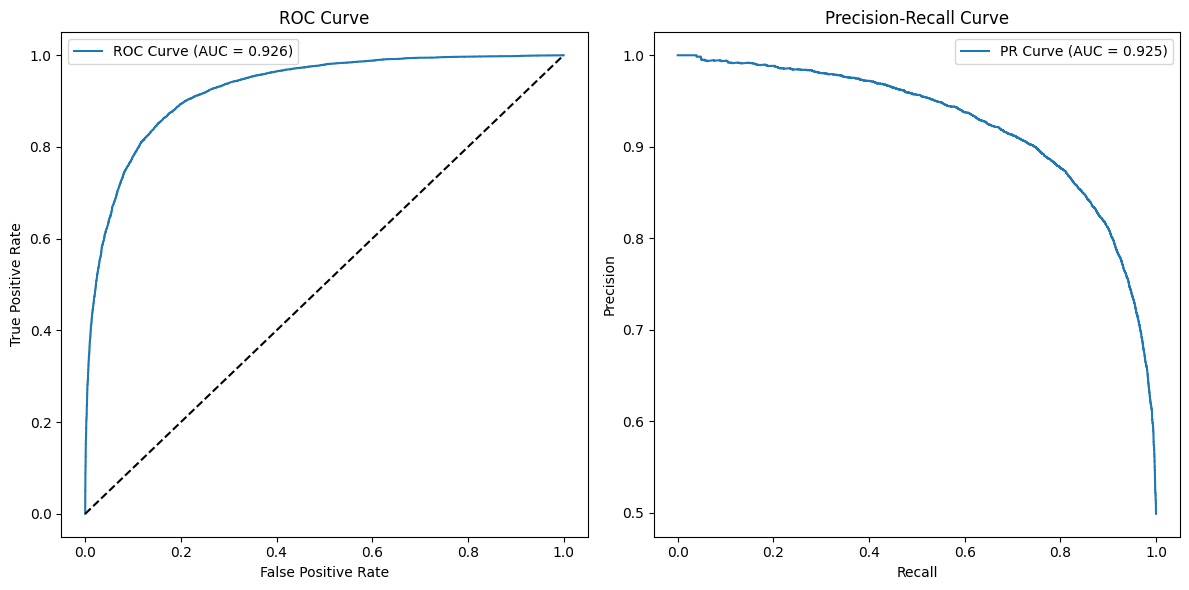

In [7]:
# Дефолтный логрег
lr_ = LogisticRegression()
lr_.fit(X_train, y_train)
y_pred = lr_.predict_proba(X_test)[:, 1]
plot_metrics(y_test, y_pred)

`Вывод`
* Значения ROC-AUC для кастомного и дефолтного логрега довольно близки, значения метрики очень хорошие (близки к 1)
* Для кастомного (с классическим градиентным спуском) и дефолтного логрега сами графики практически неотличимы

# **Часть 2. Отбор признаков (5 баллов)**

Перейдём к еще одной важной части процесса работы с данными — отбору признаков. Он нужен в следующих случаях:
- Мы хотим сократить время вычислений;
- Мы хотим избежать переобучения;
- Мы хотим попытаться улучшить качество модели за счет уменьшения признакового пространства;

В этой части мы попробуем применить несколько подходов для отбора признаков и оценим, как они влияют на качество модели и сколько времени занимают.

**Данные**

Будем использовать датасет [об обращениях клиентов по страховым случаям](https://www.kaggle.com/competitions/porto-seguro-safe-driver-prediction/data?select=train.csv). Скачайте его с Kaggle (файл `train.csv`).

Задача представляет собой бинарную классификациюю — воспользуется ли клиент страховкой на авто в ближайший год.

In [2]:
PATH_TO_DATASET = 'D:/Datasets/HSE/ML/porto.csv'

data = pd.read_csv(PATH_TO_DATASET, index_col=0)
target = data.target.values

data = data.drop('target', axis=1)

### **Задание 3. (0.25 балла)**

Прежде всего — в данных много категориальных признаков.

- Закодируйте их с помощью one-hot кодирования. Категориальные признаки отмечены постфиксом `cat`;
- Исходные колонки с категориальными признаками удалите;
- Зафиксируйте, сколько признаков получилось;

In [3]:
# split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=124)

# Нужные столбцы и кодировщик ohe
cat_cols = [x for x in X_train.columns if 'cat' in x]
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_train_ohe = ohe.fit_transform(X_train[cat_cols])
X_test_ohe = ohe.transform(X_test[cat_cols])

# Преобразуем результаты обратно в DataFrame с правильными названиями колонок
ohe_feature_names = []
for cat_name, cats in zip(cat_cols, ohe.categories_):
    ohe_feature_names += [f"{cat_name}_{cat}" for cat in cats]

X_train_ohe_df = pd.DataFrame(X_train_ohe, columns=ohe_feature_names)
X_test_ohe_df = pd.DataFrame(X_test_ohe, columns=ohe_feature_names)

# Объединяем датафреймы
X_train_ohe = pd.concat([X_train.drop(columns=cat_cols).reset_index(drop=True).copy(), X_train_ohe_df.reset_index(drop=True)], axis=1)
X_test_ohe = pd.concat([X_test.drop(columns=cat_cols).reset_index(drop=True).copy(), X_test_ohe_df.reset_index(drop=True)], axis=1)

In [4]:
X_train_ohe.head(5)

,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,...,ps_car_11_cat_95,ps_car_11_cat_96,ps_car_11_cat_97,ps_car_11_cat_98,ps_car_11_cat_99,ps_car_11_cat_100,ps_car_11_cat_101,ps_car_11_cat_102,ps_car_11_cat_103,ps_car_11_cat_104
0,1,8,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,2,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,11,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,5,0,0,1,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`Итого получилось 227 признаков`

### **Задание 4 (1 балл)**

Обучим несколько моделей, перечисленных ниже. В качестве метрики будем использовать ROC-AUC.

**Задание 4.1**

- Обучите модель логистической регрессии. Замерьте скорость обучения модели
- Обучите метод опорных векторов
- Обучите метод k ближайших соседей
- Посчитайте качество моделей (ROC-AUC) на тестовой выборке

In [5]:
# Функция обучения модели и получения метрики roc-auc
def eval_model(model, X_train, X_test, y_train, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time() - start_time
    y_pred = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred)
    return roc_auc, end_time

In [6]:
# Логистическая регрессия
logreg = LogisticRegression(random_state=42, max_iter=1000, n_jobs=6, verbose=1)
logreg_auc, logreg_time = eval_model(logreg, X_train_ohe, X_test_ohe, y_train, y_test)
logreg_auc, logreg_time

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


(0.6378880943797562, 25.77751636505127)

In [7]:
# KNeighbors
knn = KNeighborsClassifier(n_jobs=6)
knn_auc, knn_time = eval_model(knn, X_train_ohe, X_test_ohe, y_train, y_test)
knn_auc, knn_time

(0.5116073961247015, 0.45799994468688965)

In [8]:
# Для ускорения обучения SVM возьмём подвыборку (в учебном чатике разрешили)
X_train_ohe_svm = X_train_ohe.sample(20000, random_state=42)
X_test_ohe_svm = X_test_ohe.sample(20000, random_state=42)

# Индексы для y
train_ind = X_train_ohe_svm.index
test_ind = X_test_ohe_svm.index

y_train_svm = y_train[train_ind]
y_test_svm = y_test[test_ind]

# SVM
svc = SVC(probability=True, random_state=42, verbose=1)
svc_auc, svc_time = eval_model(svc, X_train_ohe_svm, X_test_ohe_svm, y_train_svm, y_test_svm)
svc_auc, svc_time

[LibSVM]

(0.5283925544799908, 83.04445052146912)

In [9]:
# Итоги
print(f"Logistic Regression: Time = {logreg_time:.2f}s, ROC-AUC = {logreg_auc:.3f}")
print(f"SVM: Time = {svc_time:.2f}s, ROC-AUC = {svc_auc:.3f}")
print(f"KNN: Time = {knn_time:.2f}s, ROC-AUC = {knn_auc:.3f}")

Logistic Regression: Time = 25.78s, ROC-AUC = 0.638
SVM: Time = 83.04s, ROC-AUC = 0.528
KNN: Time = 0.46s, ROC-AUC = 0.512


`Выводы`
* Логистическая регрессия является наиболее эффективной со стороны качества (roc-auc = 0.638), скорость обучения адекватная (26 сек.)
* KNN требует значительно меньше времени на обучение (0.46 сек.), но показывает худшее качество из трёх моделей (roc-auc = 0.512)
* Несмотря на значительно большее время обучения (83 сек.), качество SVM оказалось хуже (roc-auc = 0.528), чем у логистической регрессии, что делает её наименее эффективной среди трёх моделей (лучше уж использовать KNN с аналогичным качество, но заметно более быстрым обучением)

**Задание 4.2**

Для каждой из трех моделей (логистическая регрессия, SVM, KNN) подберите при помощи GridSearchCV на тренировочных данных оптимальные гиперпараметры:
- Для логистической регрессии: C, class_weight
- Для SVM: C, kernel, class_weight
- Для KNN: n_neighbors, weights

Затем посчитайте качество моделей на тестовой выборке.

В заданиях 4.1 и 4.2 замеряйте время обучения моделей.

In [9]:
# Функция для поиска наиболее оптимальных параметров для моделей через GridSearch
def eval_grid_search(model, param_grid, X_train, X_test, y_train, y_test, n_jobs=None):
    grid_search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=3, n_jobs=n_jobs, verbose=1)
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    end_time = time.time() - start_time
    y_pred_best = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
    best_roc_auc = roc_auc_score(y_test, y_pred_best)
    best_params = grid_search.best_params_
    return best_roc_auc, end_time, best_params

In [10]:
# Логрег
lr_params = {'C': [0.01, 0.1, 1], 'class_weight': [None, 'balanced']}
lr_best_auc, lr_time, lr_best_params = eval_grid_search(LogisticRegression(random_state=42, max_iter=1000, verbose=True), 
                                                     lr_params, X_train_ohe, X_test_ohe, y_train, y_test, n_jobs=7)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [11]:
# KNeighbors
knn_params = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
knn_best_auc, knn_time, knn_best_params = eval_grid_search(KNeighborsClassifier(), 
                                                                knn_params, X_train_ohe, X_test_ohe, y_train, y_test, n_jobs=7)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [14]:
# SVM
svc_params = {'C': [0.1, 1], 'kernel': ['linear', 'rbf'], 'class_weight': [None, 'balanced']}
svc_best_auc, svc_time, svc_best_params = eval_grid_search(SVC(probability=True, random_state=42, verbose=True), 
                                                                svc_params, X_train_ohe_svm, X_test_ohe_svm, y_train_svm, y_test_svm, n_jobs=7)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LibSVM]

In [16]:
# Итоги
print(f"Logistic Regression: Time = {lr_time:.2f}s, ROC-AUC = {lr_best_auc:.3f}")
print(f"KNN: Time = {knn_time:.2f}s, ROC-AUC = {knn_best_auc:.3f}")
print(f"SVM: Time = {svc_time:.2f}s, ROC-AUC = {svc_best_auc:.3f}")

Logistic Regression: Time = 477.97s, ROC-AUC = 0.638
KNN: Time = 1165.45s, ROC-AUC = 0.514
SVM: Time = 2015.05s, ROC-AUC = 0.618


`Выводы`
* Логистическая регрессия является наиболее эффективной моделью с точки зрения баланса между скоростью обучения (478 сек.) и качеством (roc-auc = 0.638)
* KNN требует больше времени на обучение (1165 сек.) и показывает худшее качество (roc-auc = 0.514), что делает эту модель менее предпочтительной
* SVM имеет относительно высокое качество (roc-auc = 0.618), но требует значительно больше времени на обучение (2015 сек.), что снижает её применимость

### **Встроенные методы**

**Заметим, что:**

- Время обучения моделей отличается между собой.
- Несмотря на то, что признаков много, качество модели не очень хорошее.


Попробуем решить проблемы — улучшить качество и при этом сократить пространство признаков и, соответственно, время обучения моделей.



**Отбор признаков встроеным методом.**

Начнём с отбора признаков с помощью линейной модели. Делая это, мы используем факт:
> веса линейной модели отражают  вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков.

Такой метод отбора называются встроенным в модель методом, так как он заложен в особенности модели.

**Важно:** применение этого подхода требует машстабирования признаков (подумайте, почему). Вы можете использовать приведение к стандартному нормальному распределению (`StandardScaler`) с параметрами или MinMax преобразование (`MinMaxScaler`).

### **Задание 5 (0.75 балла)**

Оставьте 150 признаков с наибольшими по модулю весами после обучения логистической регрессии.

- Замерьте скорость такого отбора признаков. (0.2 балла)

- Обучите логистическую регрессию на исходных признаках. Из них оставьте 150 лучших (с наибольшими по модулю весами).
- Масштабируйте данные — все, кроме категориальных и бинарных признаков. Зафиксируйте, сколько признаков пришлось масштабировать. (0.25 балла)
- Обучите новую модель на 150 признаках и оцените её качество. (0.15 балла)

In [34]:
# Масштабирование числовых признаков
cat_feats = [col for col in X_train_ohe.columns if X_train_ohe[col].nunique() <= 10]
non_cat_feats = [col for col in X_train_ohe.columns if col not in cat_feats]
display(f'Количество признаков для масштабирования: {len(non_cat_feats)}')

X_train_scaled = X_train_ohe.copy()
X_test_scaled = X_test_ohe.copy()

scaler = StandardScaler()
X_train_scaled[non_cat_feats] = scaler.fit_transform(X_train_ohe[non_cat_feats])
X_test_scaled[non_cat_feats] = scaler.transform(X_test_ohe[non_cat_feats])

'Количество признаков для масштабирования: 15'

In [53]:
# Оптимальные параметры для логрега, найденные в GS
c = lr_best_params['C']
c_w = lr_best_params['class_weight']

# Обучение логистической регрессии на масштабированных данных
start_time = time.time()
model = LogisticRegression(C=c, class_weight=c_w, max_iter=1000, random_state=42, verbose=True)
model.fit(X_train_scaled, y_train)

# Сортировка признаков по важности
feat_importances = np.abs(model.coef_[0])
important_feats = np.argsort(feat_importances)[-150:]
selected_feats = X_train_scaled.columns[important_feats]

# Обучение модели на отобранных признаках
X_train_selected = X_train_scaled[selected_feats]
X_test_selected = X_test_scaled[selected_feats]
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
end_time = time.time()
print(f"Время для обучения модели, получения весомых признаков и предикта: {end_time - start_time:.2f} сек.")

roc_auc_selected = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC: {roc_auc_selected}")

Время для обучения модели, получения весомых признаков и предикта: 9.39 сек.
ROC-AUC: 0.5


`ROC-AUC стал хуже при обучении на выделенных признаков, зато обучение модели стало быстрее`

### **Бонус (0.25 балла)**

Попробуйте реализовать итеративный отбор признаков, а именно:

1) Сначала отобрать около 200 признаков (действуя как в задании выше)

2) Потом повторить процедуру для отбора 150 признаков из 200 (снова действуя как в задании выше)

In [54]:
# Итеративный отбор
# Отбор 200 признаков
start_time = time.time()
important_feats_200 = np.argsort(feat_importances)[-200:]
selected_feats_200 = X_train_scaled.columns[important_feats_200]
X_train_selected_200 = X_train_scaled[selected_feats_200]
X_test_selected_200 = X_test_scaled[selected_feats_200]
model_iter = LogisticRegression(C=c, class_weight=c_w, max_iter=1000, random_state=42)
model_iter.fit(X_train_selected_200, y_train)

# Отбор 150 признаков из 200
feat_importances_200 = np.abs(model_iter.coef_[0])
important_feats_150 = np.argsort(feat_importances_200)[-150:]
fin_selected_feats = X_train_selected_200.columns[important_feats_150]
X_train_fin_selected = X_train_selected_200[fin_selected_feats]
X_test_fin_selected = X_test_selected_200[fin_selected_feats]

model_fin = LogisticRegression(C=c, class_weight=c_w, max_iter=1000, random_state=42)
model_fin.fit(X_train_fin_selected, y_train)
y_fin_pred = model_fin.predict(X_test_fin_selected)
end_time = time.time()
print(f"Время для обучения модели, получения весомых признаков и предикта: {end_time - start_time:.2f} сек.")

fin_roc_auc = roc_auc_score(y_test, y_fin_pred)
print(f"ROC-AUC: {fin_roc_auc}")

Время для обучения модели, получения весомых признаков и предикта: 7.98 сек.
ROC-AUC: 0.5


`Значения метрики ROC-AUC получились одинаковые при двух подходах, время обучения при втором подходе быстрее на полторы секунды`

### **Задание 6 (0.5 балла)**

Также можно задать отбор признаков, используя другие свойства модели. Вспомним, что L1-регуляризация тоже умеет отбирать признаки.

- Обучите модель на исходных данных. Подберите по сетке (GridSearch) наилучшее значение коэффициента регуляризации C. (0.1 балла)

- Посмотрите сколько признаков отобрала модель с найденным оптимальным C?
  - Сначала посчитайте только число ненулевых весов
  - Затем посчитайте число весов, которые после округления до двух знаков после запятой не равны нулю (0.25 балла)

Удалось ли отобрать 150 признаков за 1 шаг? (0.05 балла)

In [17]:
# Сетка значений для гиперпараметра C
params = {'C': [0.1, 1, 10]}

# GridSearch для подбора оптимального C
gs = GridSearchCV(LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000), params, cv=3, scoring='f1', n_jobs=7, verbose=2)
gs.fit(X_train_scaled, y_train)

# Лучшая модель и коэффициенты
best_model = gs.best_estimator_
best_C = gs.best_params_['C']
coefficients = best_model.coef_

# Ненулевые коэффициенты
non_zero_w = np.sum(coefficients != 0)
round_non_zero_w = np.sum(np.round(coefficients, 2) != 0)

best_C, non_zero_w, round_non_zero_w

Fitting 3 folds for each of 3 candidates, totalling 9 fits


(10, 222, 204)

In [26]:
y_pred = best_model.predict(X_test_scaled)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC: {roc_auc:.2f}")

ROC-AUC: 0.50


`С оптимальным C=10 для модели логистической регрессии за 1 шаг не получилось отобрать 150 признаков (с округлением их значение равно около 204), при этом значение ROC-AUC как на прошлых методах (0.5)`

### **Методы фильтрации**

Также можно отбирать признаки, применяя методы математической статистики. А именно, в нашем случае, через подсчёт некоторой функции для каждого признака. На основании значений этой функции (она называется *статистикой*) мы можем оставлять наиболее важные признаки. Методы этого семейства называют *фильтрационными* или *filter methods*.

**Что проверяем:**

Равны ли математические ожидания (то есть выборочные средние) распределений признака для двух разных классов? Если они различаются, значит и сами распределения разные. И можно сделать вывод, что по этому признаку модель сможет отличить один класс от другого. А если распределения неотличимы и значение статистики маленькое, то и признак бесполезен.


Для проверки будем считать t-статистику:

$$t(x) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ s^2_+ + n_- s^2_-}{n_+ + n_-}}},$$

где $\mu$, $s$, $n$ соответственно среднее, среднеквадратичное отклонение и количество объектов каждого из классов.

**Примечание:** Если у вас была данная тема на курсе по математической статистике, то вы без труда узнаете статистику гипотезы о разности средних при неизвестных дисперсиях.

Хотя мы и не используем статистическое тестирование явно, предпосылки о том, что наблюдения независимы, одинаково распределены и $n$ велико, должны соблюдаться, иначе статистика не имеет смысла. Но у нас большая выборка, поэтому они выполняются.

Для отбора признаков по t-статистике мы возьмём признаки с наибольшим значением статистики.

### **Задание 7 (1 балла)**

- Масштабируйте признаки исходного датасета — все, кроме категориальных и бинарных.
- Выделите непрерывные признаки (те, которые масштабировали)
- Посчитайте значения t-статистики. Оставьте ***половину*** признаков с наибольшим значением статистики, объедините их с категориальными и бинарными.
- Обучите модель логистической регрессии и замерьте качество.

Не забудьте замерить скорость отбора признаков в этом случаев.

In [ ]:
# Расчет t-статистики для непрерывных признаков
start_time = time.time()
t_stats = []
for feat in non_cat_feats:
    class_0 = X_train[y_train == 0][feat]
    class_1 = X_train[y_train == 1][feat]
    t_stat, _ = ttest_ind(class_0, class_1, equal_var=False)
    t_stats.append((feat, abs(t_stat)))

# Сортируем по значению t-статистики
sorted_feats = sorted(t_stats, key=lambda x: x[1], reverse=True)
selected_feats= [f[0] for f in sorted_feats[:len(sorted_feats)//2]]
fin_feats = selected_feats + cat_feats
feat_selection_time = time.time() - start_time

# Модель
model = LogisticRegression(solver='liblinear', max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)

# Итоги
print(f"Отобрано признаков: {len(fin_feats)}")
print(f"Время отбора признаков: {feat_selection_time:.4f} секунд")
print(f"ROC-AUC: {roc_auc:.4f}")

Отобрано признаков: 219
Время отбора признаков: 0.9340 секунд
ROC-AUC: 0.5000


`Время для отбора признаков и обучения модели получилось значительно меньше, чем при применении встроенных методов, скорость выросла примерно в 10 раз, при этом ROC-AUC точно такой же`

### **Методы-обёртки**

### **Задание 8 (бонус, 1 балл)**


Заключительный из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди каждый из признаков и смотрим, как это влияет на качество модели, обученной без удаленного признака. Удаляем признаки таким жадным способом.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только на финальной оценке качества.

Сделайте одну итерацию и прикиньте, сколько времени займёт такой отбор признаков. Кажется, что чересчур много. Давайте возьмём маленький сэмпл данных (например, в 10 тысяч объектов), что сильно уменьшит время итерации. Теперь это долго, но уже приемлимо.

Если это всё ещё долго для вашего комьютера, можете попробовать брать не по одному признаку, а сразу по пять (и удалять сразу тоже по 5). Для этого перед каждой итерацией удаления делите заново все признаки на группы по 5 штук.

Снова оставьте только 150 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [ ]:
# В этот раз без бонуса)

Опционально (это не оценивается) можете рассмотреть более интересные стратегии отбора, чем жадная. Например, генетические алгоритмы. Можно закодировать бинарным вектором, включаем мы или нет тот или иной признак в модель. А дальше генетическим алгоритмом оптимизировать этот вектор. Всё ещё не быстро, но точно быстрее жадного.


### **Задание 9 (0.25 балла)**

Подведите итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству? Если не делали бонус — сравните встроенный метод и метод фильтрации.

`Выводы`
* Лучшие результаты по метрике ROC-AUC потенциально могут дать методы 2 (итеративный отбор) и 3 (GridSearch), так как они обеспечивают более глубокую оптимизацию модели и признаков, однако на нашей выборке все методы дали одинаковое значение метрики
* Если сравнивать скорость, метод 4 (t-статистика) оказался самым быстрым - 0.9 сек., метод 3 (GridSearch) самым медленным - 242 сек., метод 1 (важность признаков) и метод 2 (итеративный) примерно равны по скорости выполнения (8-9 сек.)
* Наиболее просто оказалось внедрить метод 3 (GridSearch)

# **Часть 3. Обучение моделей на текстовых данных. (3.5 балла)**

 ### **Подготовка данных из реального мира.**

Загрузите данные с конкурса  [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/data?select=train.csv) (вам нужна только обучающая выборка, файл `train.csv`). Задача состоит в определении постов, сообщающих о чрезвычайной ситуации. В рамках домашнего задания, этот набор данных будет отличным полем для тренировки в обработке признаков.

In [10]:
PATH = 'D:/Datasets/HSE/ML/nlp.csv'
data = pd.read_csv(PATH)

data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### **Задание 10. Базовая предобработка (0.5 баллов).**

- Выведите на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [11]:
display(data.isna().sum())
data = data.fillna('')

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

`Пропуски обнаружены и побеждены!`

- Проанализируйте количество уникальных значений в числовых столбцах. Сделайте выводы.

In [12]:
data.select_dtypes(np.number).nunique()

id        7613
target       2
dtype: int64

`В данных 7613 уникальных айдишников и всего 2 варианта для таргета (1-есть происшествие, 0-нет)`

- Проанализируйте соотношение классов в целевой переменной. Почему значимо это учитывать?

In [13]:
data['target'].value_counts(normalize=True)

target
0    0.57034
1    0.42966
Name: proportion, dtype: float64

`В данных 57% класса 0 и 43% класса 1, довольно близкое соотношение. Это важно учитывать, потому что это может привести к более частому предсказанию класса 0, также это важно для выбора правильной метрики качества модели (и выбор самой модели)`

- Объедините все три текстовых столбца в один (вам поможет конкатенация строк)

In [14]:
data['text_full'] = data['text'] + ' ' + data['keyword'] + ' ' + data['location']
data.head()

,id,keyword,location,text,target,text_full
0,1,,,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...
1,4,,,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada
2,5,,,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...
3,6,,,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or..."
4,7,,,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...


- Наконец, поделите данные на тренировочную и тестовую выборки.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data['text_full'], data['target'], test_size=0.2, random_state=124)

### **Задание 11. Базовые модели. (1 балл).**

Данные, собираемые с сайтов, часто содержат мусор не информативный для моделей. Посмотрите, какого качества данные здесь. Для этого:
- Примените CountVectorizer из sklearn к сырым даным. Какого размера получилась матрица?

In [16]:
# Сразу оформлю решение в виде пайплайна для ускорения процесса
# Логрег
pipeline_lr = Pipeline([('vectorizer', CountVectorizer()),('classifier', LogisticRegression(max_iter=1000))])

# SVC
pipeline_svc = Pipeline([('vectorizer', CountVectorizer()), ('classifier', SVC())])

- Обучите логистическую регрессию на полученном наборе. Какое качество `f1` у модели получилось на тестовых данных?

In [18]:
# CountVectorizer c lr с дефолтными параметрами, метрику возьмём f1_weighted для учёта дизбаланса классов
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)
init_f1_lr = f1_score(y_test, y_pred_lr, average='weighted')
display(f'f1_weighted_lr: {init_f1_lr:.3f}')

'f1_weighted_lr: 0.799'

- Обучите SVC на тех же данных с гиперпараметрами по умолчанию. Измерьте качество (`f1`) на тестовых данных и опишите результат. Проанализируйте качество и скорость обучения.

In [19]:
# SVC
pipeline_svc.fit(X_train, y_train)
y_pred_svc = pipeline_svc.predict(X_test)
init_f1_svc = f1_score(y_test, y_pred_svc, average='weighted')
display(f'f1_weighted_svc: {init_f1_svc:.3f}')

'f1_weighted_svc: 0.792'

### **Задание 12. Улучшение базовых моделей за счет данных. (0.5 балла).**

- Подберите гиперпараметры CountVectorizer так, чтобы признаков было минимум в 4 раза меньше, чем объектов, а качество модели при этом изменилось не более чем на $\pm 0.07$. Опишите подобранные гиперпараметры и на что они влияют (0.5 балла).

Обучайте и логистическую регрессию, и SVC.

In [20]:
for i in [1500, 3000]:
    # Подбор гиперпараметров CountVectorizer
    params_vectorizer = {
        'vectorizer__max_features': [i], # максимальное количество признаков, которые будут включены в словарь (включаются самые частотные слова)
        'vectorizer__min_df': [1, 3],  # минимальная частота документа, ниже которой слова игнорируются (для исключения редких слов)
        'vectorizer__max_df': [0.6, 0.8], # максимальная частота документа, выше которой слова игнорируются (для исключения "шумовых" слов)
        'vectorizer__ngram_range': [(1, 1), (1, 2)], # диапазон n-грамм, который учитывается при построении словаря (для учёта контекста словосочетаний)
        'vectorizer__stop_words': ['english'] # список стоп-слов английского языка, которые исключаются из анализа
    }

    # Логрег
    grid_lr = GridSearchCV(pipeline_lr, params_vectorizer, scoring='f1_weighted', cv=3, n_jobs=7)
    grid_lr.fit(X_train, y_train)
    optimized_lr_f1 = f1_score(y_test, grid_lr.best_estimator_.predict(X_test), average='weighted')
    display(f'f1_weighted_lr: {optimized_lr_f1:.3f}')

    # SVC
    grid_svc = GridSearchCV(pipeline_svc, params_vectorizer, scoring='f1_weighted', cv=3, n_jobs=7)
    grid_svc.fit(X_train, y_train)
    optimized_svc_f1 = f1_score(y_test, grid_svc.best_estimator_.predict(X_test), average='weighted')
    display(f'f1_weighted_svc: {optimized_svc_f1:.3f}')

    # Проверяем размерность признаков
    best_vectorizer = grid_lr.best_estimator_.named_steps['vectorizer']
    X_train_transformed = best_vectorizer.fit_transform(X_train)
    num_samples, num_features = X_train_transformed.shape

    print(f"Количество объектов: {num_samples}")
    print(f"Количество признаков: {num_features}")
    if num_features <= num_samples / 4:
        print("Условие выполнено: признаков минимум в 4 раза меньше, чем объектов.")
    else:
        print("Условие не выполнено: признаков больше, чем требуется.")

'f1_weighted_lr: 0.790'

'f1_weighted_svc: 0.790'

Количество объектов: 6090
Количество признаков: 1500
Условие выполнено: признаков минимум в 4 раза меньше, чем объектов.


'f1_weighted_lr: 0.790'

'f1_weighted_svc: 0.792'

Количество объектов: 6090
Количество признаков: 3000
Условие не выполнено: признаков больше, чем требуется.


`Условия задачи по количеству признаков и по изменению качества выполнили`

In [28]:
# Оптимальные параметры для CountVectorizer, найденные через GS
print(grid_lr.best_params_)
print(grid_svc.best_params_)

{'vectorizer__max_df': 0.6, 'vectorizer__max_features': 3000, 'vectorizer__min_df': 3, 'vectorizer__ngram_range': (1, 2), 'vectorizer__stop_words': 'english'}
{'vectorizer__max_df': 0.6, 'vectorizer__max_features': 3000, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 1), 'vectorizer__stop_words': 'english'}


### **Задание 13. Улучшение базовых моделей путем подбора гиперпараметров. (1 балл).**
- Попробуйте подбирать разные гиперпараметры для логистической регрессии. Опишите подбираемые гиперапарметры и ваши результаты (0.5 балла)

In [25]:
# Логрег
params_lr = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__solver': ['lbfgs', 'liblinear'],
}

grid_lr_model = GridSearchCV(grid_lr.best_estimator_, params_lr, scoring='f1_weighted', cv=3, n_jobs=7)
grid_lr_model.fit(X_train, y_train)
best_lr_f1 = f1_score(y_test, grid_lr_model.best_estimator_.predict(X_test), average='weighted')
display(grid_lr_model.best_params_)
display(f'f1_weighted_lr: {best_lr_f1:.3f}')

{'classifier__C': 0.1, 'classifier__solver': 'liblinear'}

'f1_weighted_lr: 0.797'

`Логистическая регрессия`
* classifier__C - регуляризирующий параметр, отвечает за степень штрафа модели при переобучении (C < 1 - усиление регуляризации, C > 1 - ослабление)
* classifier__solver - алгоритм оптимизации для поиска оптимальных весов (lbfgs - быстрый метод для средних наборов данных, liblinear - для небольших датасетов или данных с разреженными признаками)
* Лучший набор параметров `'classifier__C': 0.1, 'classifier__solver': 'liblinear'`, значение метрики f1_weighted немного выросло (с 0.79 до 0.797) по сравнению с результатами без подбора гиперпараметров модели

- Попробуйте подбирать разные гиперпараметры для модели SVC. Опишите подбираемые гиперапарметры и ваши результаты (0.5 балла)

In [27]:
# SVC
params_svc = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto'],
}

grid_svc_model = GridSearchCV(grid_svc.best_estimator_, params_svc, scoring='f1_weighted', cv=3, n_jobs=7)
grid_svc_model.fit(X_train, y_train)
best_svc_f1 = f1_score(y_test, grid_svc_model.best_estimator_.predict(X_test), average='weighted')
display(grid_svc_model.best_params_)
display(f'f1_weighted_svc: {best_svc_f1:.3f}')

{'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}

'f1_weighted_svc: 0.792'

`SVC`
* classifier__C - точно так же, как у логистической регрессии, регуляризирующий параметр
* classifier__kernel - ядро модели, которое разделяет данные на классы, linear - линейное ядро, , которое хорошо работает с линейно разделимыми данными, rbf - радиальное базисное ядро, подходит для нелинейных зависимостей
* classifier__gamma - коэффициент для нелинейных ядер (rbf), scale - автоматический расчет значения на основе данных, auto - использование 1 / кол-во признаков
* Значение метрики f1_weighted осталось таким же (0.792)

### **Задание 14. (0.5 балла)**

Оформите два пайплайна:
- для модели регрессии
- для SVC модели

в пайплайн должны входить предобработка сырого датасета и обучение модели.

`Пайплайны были оформлены в заданиях выше`

### **Выводы**

Зафиксируйте выводы работы. Проанализируйте, что проделано и какие результаты вы получили. Заполняется в свободной форме.

`Заданий было много, местами было непросто, но со всем справились!`
* Была написана кастомная логистическая регрессия, проведено сравнение с коробочной версией
* Было проведено сравние качества и скорости обучения моделей логистической регрессии, CVC и KNN, проведено подбор оптимальных параметров для этих моделей
* Применены различные методы отбора признаков для обучения моделей, проведено сравнение методов между собой
* Обучены модели логистической регрессии и SVC на основе CountVectorizer по текстовым данным, подобраны оптимальные параметры через GridSearch

## Чей кот?

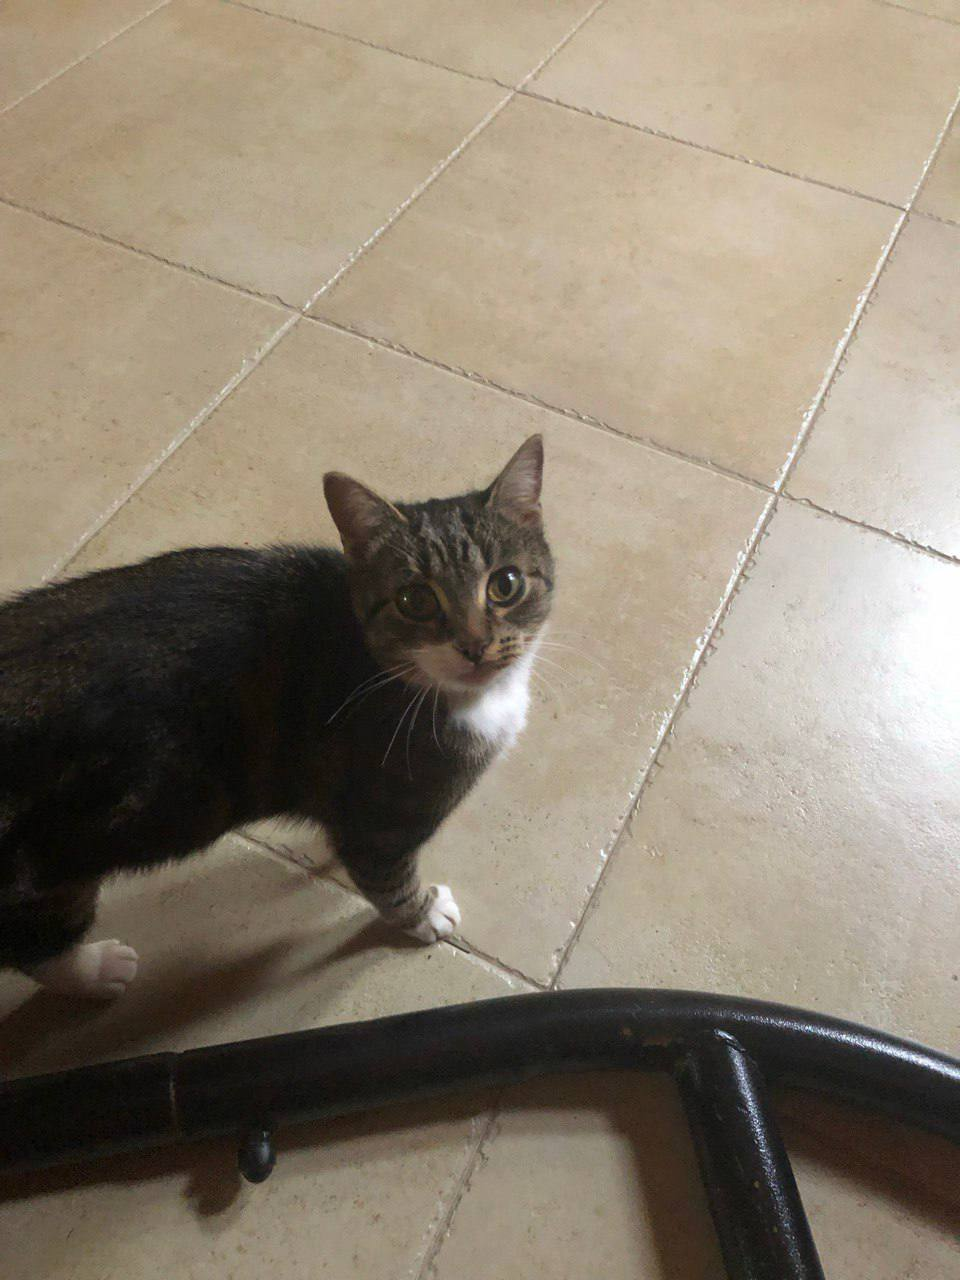